In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

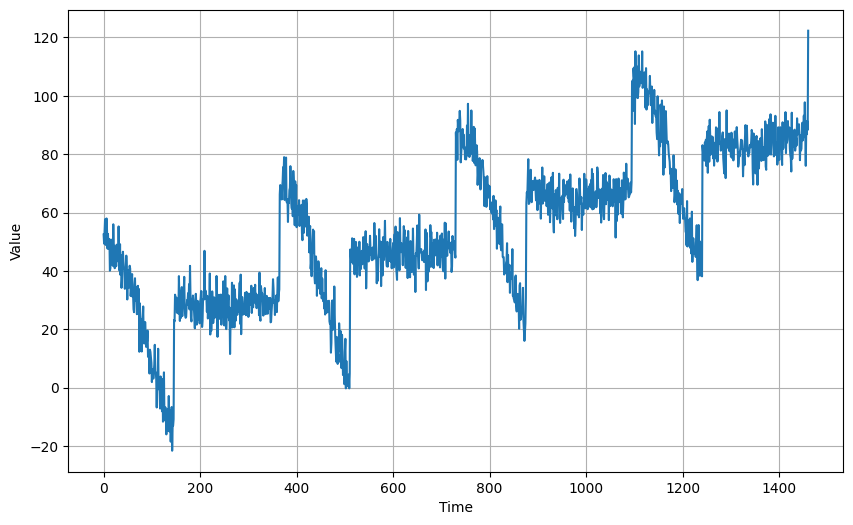

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=5,
                        strides=1, padding="causal",
                        activation="relu",
                        input_shape=[None, 1]),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


C:\Users\sebas\anaconda3\envs\tensorflow_1\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 10s 133ms/step - loss: 32.5921 - mae: 33.0904 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 32.1695 - mae: 32.6676 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 31.4695 - mae: 31.9674 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 30.5969 - mae: 31.0948 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 29.5458 - mae: 30.0437 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 13ms/step - loss: 28.3324 - mae: 28.8299 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 9ms/step - loss: 26.9286 - mae: 27.4266 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 10ms/step - loss: 25.3062 - mae: 25.8035 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 10ms/step - loss: 23.4507 - mae: 23.9474 - lr: 2.5119e-08
Epoc

(1e-08, 0.0001, 0.0, 30.0)

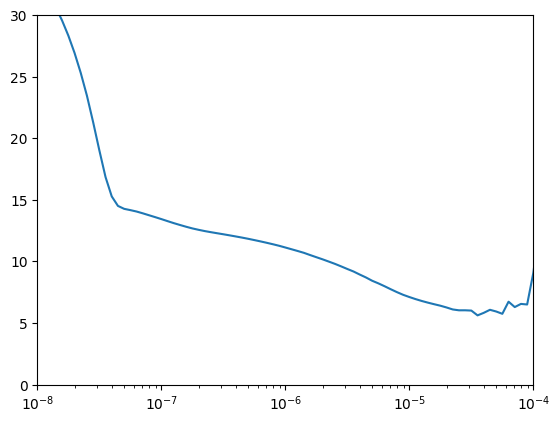

In [6]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=5,
                        strides=1, padding="causal",
                        activation="relu",
                        input_shape=[None, 1]),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 3s 147ms/step - loss: 22.8956 - mae: 23.3897 - val_loss: 27.0740 - val_mae: 27.5696
Epoch 2/500
8/8 [==============================] - 0s 30ms/step - loss: 17.2275 - mae: 17.7189 - val_loss: 21.9434 - val_mae: 22.4372
Epoch 3/500
8/8 [==============================] - 0s 39ms/step - loss: 12.1793 - mae: 12.6679 - val_loss: 21.3693 - val_mae: 21.8658
Epoch 4/500
8/8 [==============================] - 0s 33ms/step - loss: 10.3739 - mae: 10.8611 - val_loss: 12.6692 - val_mae: 13.1569
Epoch 5/500
8/8 [==============================] - 0s 25ms/step - loss: 9.4398 - mae: 9.9267 - val_loss: 17.1537 - val_mae: 17.6483
Epoch 6/500
8/8 [==============================] - 0s 21ms/step - loss: 8.5342 - mae: 9.0196 - val_loss: 14.4050 - val_mae: 14.8956
Epoch 7/500
8/8 [==============================] - 0s 21ms/step - loss: 7.9217 - mae: 8.4062 - val_loss: 16.2141 - val_mae: 16.7076
Epoch 8/500
8/8 [==============================] - 0s 21ms/step - l

In [8]:
model = keras.models.load_model("my_checkpoint.h5")

In [9]:
rnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

45/45 [==============================] - 1s 8ms/step


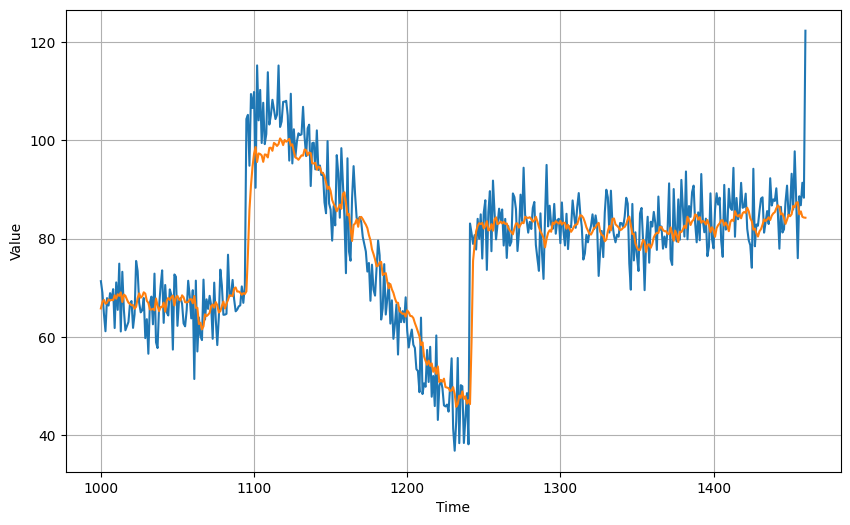

In [10]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [11]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

4.9552703

In [12]:
# fully convolutional

In [13]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
        keras.layers.Conv1D(filters=32,
                            kernel_size=2,
                            strides=1,
                            dilation_rate=dilation_rate,
                            padding="causal",
                            activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


C:\Users\sebas\anaconda3\envs\tensorflow_1\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 1s 24ms/step - loss: 41.2882 - mae: 41.7873 - lr: 1.0000e-04
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 41.0231 - mae: 41.5223 - lr: 1.0798e-04
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 40.7360 - mae: 41.2353 - lr: 1.1659e-04
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 40.3774 - mae: 40.8768 - lr: 1.2589e-04
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 39.8738 - mae: 40.3731 - lr: 1.3594e-04
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 39.1225 - mae: 39.6215 - lr: 1.4678e-04
Epoch 7/100
8/8 [==============================] - 0s 8ms/step - loss: 37.9684 - mae: 38.4671 - lr: 1.5849e-04
Epoch 8/100
8/8 [==============================] - 0s 8ms/step - loss: 36.1879 - mae: 36.6861 - lr: 1.7113e-04
Epoch 9/100
8/8 [==============================] - 0s 8ms/step - loss: 33.2760 - mae: 33.7746 - lr: 1.8478e-04
Epoch 10/100

(0.0001, 0.1, 0.0, 30.0)

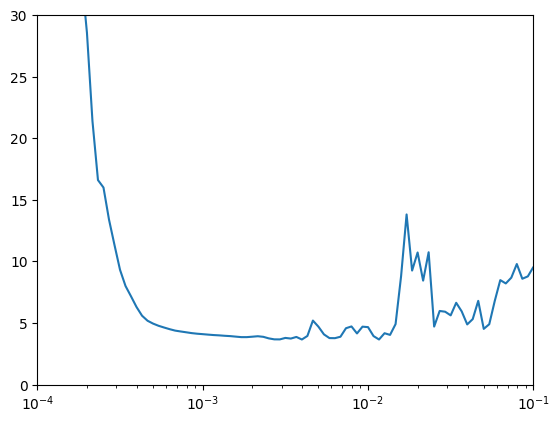

In [14]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
        keras.layers.Conv1D(filters=32,
                            kernel_size=2,
                            strides=1,
                            dilation_rate=dilation_rate,
                            padding="causal",
                            activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(lr=3e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 2s 92ms/step - loss: 42.2594 - mae: 42.7584 - val_loss: 78.0415 - val_mae: 78.5415
Epoch 2/500
8/8 [==============================] - 0s 28ms/step - loss: 41.4979 - mae: 41.9969 - val_loss: 76.5245 - val_mae: 77.0245
Epoch 3/500
8/8 [==============================] - 0s 28ms/step - loss: 40.5325 - mae: 41.0314 - val_loss: 74.1062 - val_mae: 74.6062
Epoch 4/500
8/8 [==============================] - 0s 29ms/step - loss: 38.8582 - mae: 39.3570 - val_loss: 69.3805 - val_mae: 69.8805
Epoch 5/500
8/8 [==============================] - 0s 28ms/step - loss: 35.5269 - mae: 36.0255 - val_loss: 60.1755 - val_mae: 60.6755
Epoch 6/500
8/8 [==============================] - 0s 27ms/step - loss: 29.5370 - mae: 30.0351 - val_loss: 43.8549 - val_mae: 44.3540
Epoch 7/500
8/8 [==============================] - 0s 25ms/step - loss: 21.4261 - mae: 21.9214 - val_loss: 31.8382 - val_mae: 32.3355
Epoch 8/500
8/8 [==============================] - 0s 24ms/ste

In [16]:
model = keras.models.load_model("my_checkpoint.h5")

In [17]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

44/44 [==============================] - 0s 5ms/step


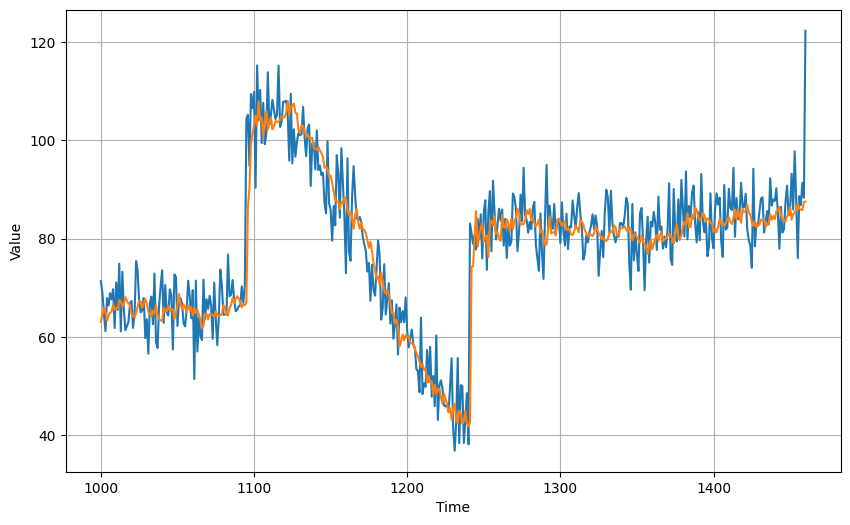

In [18]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [19]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

4.6406355